In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az


In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Importing Grades

Grades = pd.read_csv('grades.csv', index_col=0)
# Filter out exact grades = 0.0 or 1.0
Grades = Grades[(Grades['grade'] > 0.0) & (Grades['grade'] < 1.0)]

Grades_2018 = Grades[Grades['year'] == 2018]
Grades_2019 = Grades[Grades['year'] == 2019]
Grades_2020 = Grades[Grades['year'] == 2020]
Grades_2021 = Grades[Grades['year'] == 2021]
# Grades_2022 = Grades[Grades['year'] == 2022]
# Grades_2023 = Grades[Grades['year'] == 2023]

Grades_per_year = {
    2018: Grades_2018,
    2019: Grades_2019,
    2020: Grades_2020,
    2021: Grades_2021,
    # 2022: Grades_2022,
    # 2023: Grades_2023
}

# year = 2018
# year = 2022
year = 2018


In [4]:
print(Grades_per_year[year]['grade'].values)

[0.64 0.82 0.85 0.65 0.68 0.68 0.81 0.75 0.63 0.81 0.8  0.75 0.76 0.77
 0.71 0.73 0.42 0.63 0.49 0.57 0.78 0.74 0.59 0.88 0.73 0.57 0.83 0.94
 0.74 0.92 0.64 0.9  0.71 0.97 0.43 0.78 0.35 0.7  0.64 0.42 0.48 0.68
 0.81 0.41 0.56 0.73 0.67 0.83 0.97 0.61 0.8  0.9  0.66 0.84 0.78 0.56
 0.76 0.75 0.76 0.67 0.56 0.39 0.83 0.56 0.7  0.69 0.89 0.83 0.49 0.71
 0.51 0.67 0.79 0.78 0.49 0.86 0.82 0.67 0.7  0.28 0.85 0.7  0.72 0.9
 0.66 0.87 0.61 0.84 0.72 0.89 0.64 0.46 0.6  0.81 0.87 0.72 0.88 0.69
 0.76 0.68 0.76 0.88 0.8  0.43 0.79 0.51 0.71 0.96 0.81 0.6  0.88 0.57
 0.55 0.82 0.75 0.51 0.89 0.74 0.47 0.55 0.83 0.9  0.51 0.78 0.78 0.85
 0.97 0.62 0.72 0.68 0.86 0.51 0.92 0.5  0.75 0.42 0.57 0.96 0.78 0.42
 0.72 0.88 0.63 0.57 0.5  0.8  0.7  0.56 0.59 0.47 0.68 0.72 0.54 0.79
 0.84 0.77 0.82 0.57 0.96 0.86 0.67 0.73 0.86 0.69 0.76 0.77 0.59 0.51
 0.78 0.32 0.62 0.8  0.47 0.74 0.59 0.75 0.91 0.54 0.62 0.69 0.75 0.7
 0.62 0.85 0.53 0.69 0.59 0.52 0.87 0.81 0.98 0.54 0.56 0.46 0.55 0.47
 0.69 0.

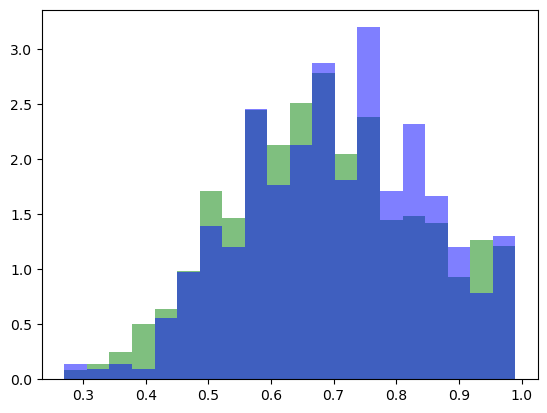

In [5]:
# Histogram of grades
plt.hist(Grades['grade'], bins=20, density=True, alpha=0.5, color='g', label='Grades')
plt.hist(Grades_per_year[year]['grade'], bins=20, density=True, alpha=0.5, color='b', label=f'Grades {year}')
plt.show()

In [6]:
# Define Stan Model
my_mixtures = '''
data{
  int <lower=0> N; // number of observations
  vector[N] x; // observations
  real prior_alpha_1; // prior alpha
  real prior_beta_1; // prior beta
  real prior_alpha_2; // prior alpha
  real prior_beta_2; // prior beta
}


parameters{
  ordered[2] alpha; // ordered beta parameters
  vector<lower=0>[2] beta; // beta parameters
  real<lower=0, upper=1> theta; // mixing proportion
}

//parameters{
//  vector<lower=0>[2] alpha; // beta parameters
//  ordered[2] beta; // ordered beta parameters
//  real<lower=0, upper=1> theta; // mixing proportion
//}

model {
  // Priors
  alpha[1] ~ normal(prior_alpha_1, 2);
  alpha[2] ~ normal(prior_alpha_2, 2);
  
  beta[1] ~ normal(prior_beta_1, 2);
  beta[2] ~ normal(prior_beta_2, 2);
  
  theta ~ beta(1, 1); // uniform prior

  // Likelihood: mixture of two Betas
  for (n in 1:N) {
    target += log_mix(
      theta,
      beta_lpdf(x[n] | alpha[1], beta[1]),
      beta_lpdf(x[n] | alpha[2], beta[2])
    );
}
}
'''

In [7]:
# Define prior parameters
prior_alpha_1 = 10
prior_beta_1 = 3
prior_alpha_2 = 3
prior_beta_2 = 10


my_data = {
    'N': len(Grades_per_year[year]),
    'x': Grades_per_year[year]['grade'].values,
    'prior_alpha_1': prior_alpha_1,
    'prior_beta_1': prior_beta_1,
    'prior_alpha_2': prior_alpha_2,
    'prior_beta_2': prior_beta_2}

In [8]:
model = stan.build(
    my_mixtures,
    data=my_data,
    random_seed=12345
)

Building...

In file included from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/tbb/tbb_profiling.h:123,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/tbb/task.h:36,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/tbb/task_arena.h:23,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/stan/math/prim/core/init_threadpool_tbb.hpp:18,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/stan/math/prim/core.hpp:4,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/Eigen_NumTraits.hpp:5,
                 from /home/fedor-tairli/anaconda3/envs/BML/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7,
                 from /home/fedor-tairli/anac


Building: 28.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_gcwyrfxt/model_l3qqm3ad.stan', line 32, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [9]:
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1301/6000)
Sampling:  23% (1401/6000)
Sampling:  27% (1601/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  42% (2500/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Sampling:  48% (2902/6000)
Sampling:  50% (3002/6000)
Sampling:  52% (3102/6000)
Sampling:  53% (3201/6000)
Sampling:  55% (3300/6000)
Sampling:  57% (3400/6000)
Sampling:  60% (3600/6000)
Sampling:  62% (3700/6000)
Sampling:  63% (3800/6000)
Samplin

In [10]:
results = fit.to_frame()

In [11]:
results

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha.1,alpha.2,beta.1,beta.2,theta
draws,,,,,,,,,,,,
0,313.969282,0.793090,0.154300,4.0,15.0,0.0,-311.367430,6.063578,8.559539,1.389080,4.586212,0.300066
1,306.243795,0.993350,0.219877,5.0,47.0,0.0,-304.450416,9.230056,9.415711,4.750086,1.457854,0.805810
2,305.561262,0.999147,0.229385,4.0,31.0,0.0,-296.870758,7.002209,7.881580,3.404072,1.481578,0.823350
3,312.265041,0.980045,0.118556,5.0,31.0,0.0,-306.467532,7.081058,7.647630,1.519086,3.965706,0.275854
4,311.433213,0.747406,0.154300,3.0,15.0,0.0,-310.420418,6.437416,9.246413,1.244311,4.893650,0.303889
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,314.061854,0.987996,0.118556,4.0,31.0,0.0,-312.089095,7.869377,8.854472,1.679352,4.688548,0.305500
3996,310.981982,0.877421,0.154300,3.0,7.0,0.0,-309.827512,8.354394,9.031647,1.748255,4.884258,0.229218
3997,305.748006,0.957249,0.219877,3.0,15.0,0.0,-303.404755,8.154135,8.182342,4.306329,1.536428,0.778756


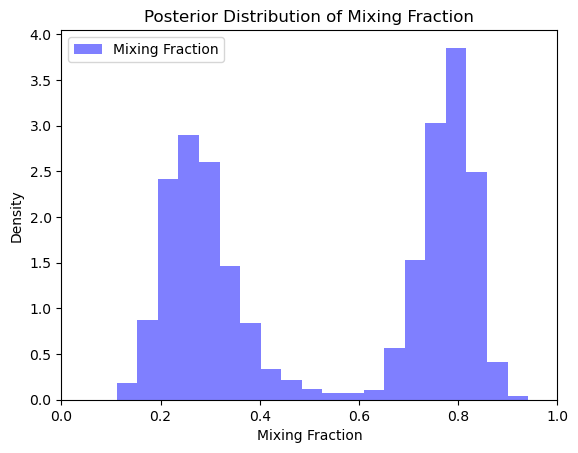

In [12]:
# Check the mixing fraction
plt.hist(results['theta'], bins=20, density=True, alpha=0.5, color='blue', label='Mixing Fraction')
plt.xlabel('Mixing Fraction')
plt.ylabel('Density')
plt.title('Posterior Distribution of Mixing Fraction')
plt.legend()
plt.xlim(0, 1)
plt.show()


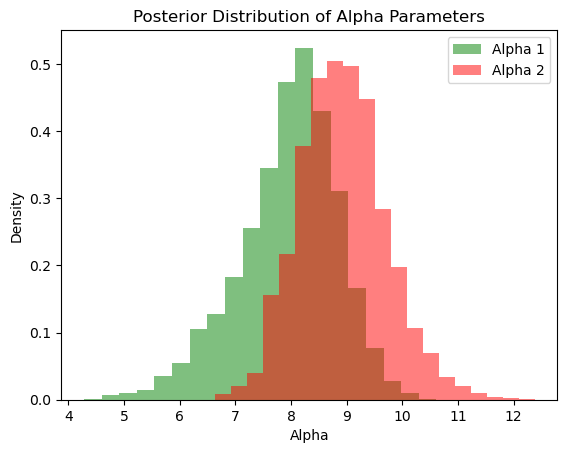

In [13]:
# Alpha Histogram
plt.hist(results['alpha.1'], bins=20, density=True, alpha=0.5, color='g', label='Alpha 1')
plt.hist(results['alpha.2'], bins=20, density=True, alpha=0.5, color='r', label='Alpha 2')
plt.xlabel('Alpha')
plt.ylabel('Density')
plt.title('Posterior Distribution of Alpha Parameters')
plt.legend()
plt.show()

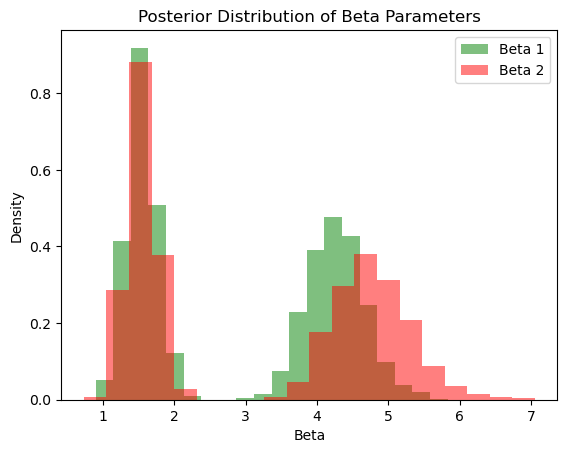

In [14]:
# Beta Histogram
plt.hist(results['beta.1'], bins=20, density=True, alpha=0.5, color='g', label='Beta 1')
plt.hist(results['beta.2'], bins=20, density=True, alpha=0.5, color='r', label='Beta 2')
plt.xlabel('Beta')
plt.ylabel('Density')
plt.title('Posterior Distribution of Beta Parameters')
plt.legend()
plt.show()

Text(0, 0.5, 'Density')

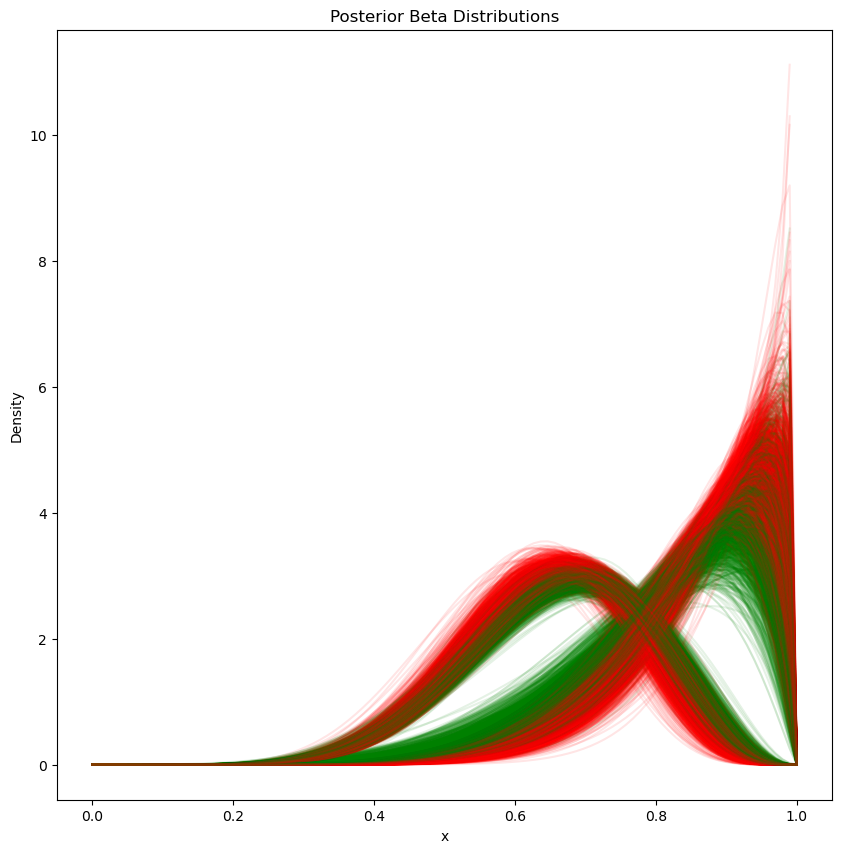

In [15]:
# Plot the posterior beta distributions
# Keep theta constant
Theta = 0.3

plt.figure(figsize=(10,10))

for i in range(len(results)):
    x = np.linspace(0, 1, 100)
    y1 = stats.beta.pdf(x, results['alpha.1'][i], results['beta.1'][i])
    y2 = stats.beta.pdf(x, results['alpha.2'][i], results['beta.2'][i])
    
    # plt.plot(x, Theta * y1 + (1 - Theta) * y2, color='blue', alpha=0.1)
    plt.plot(x, y1, color='green', alpha=0.1)
    plt.plot(x, y2, color='red', alpha=0.1)
plt.title('Posterior Beta Distributions')
plt.xlabel('x')
plt.ylabel('Density')
# plt.xlim(0, 1)
# plt.ylim(0, 5)





In [16]:
# Calculate the mean of the posterior distributions
Mean_fraction = results['theta'].mean()

Mean_Cluster_1 = stats.beta.mean(results['alpha.1'].mean(), results['beta.1'].mean())
Mean_Cluster_2 = stats.beta.mean(results['alpha.2'].mean(), results['beta.2'].mean())

print(f'Mean Mixing Fraction: {Mean_fraction:.3f}')
print(f'Mean Cluster 1: {Mean_Cluster_1:.3f}')
print(f'Mean Cluster 2: {Mean_Cluster_2:.3f}')


Mean Mixing Fraction: 0.223
Mean Cluster 1: 0.861
Mean Cluster 2: 0.658


In [ ]:
Summary_over_years = {}
for i in range(2018, 2022):
    # if i ==2019: continue
    print(f'Processing year {i}...')
    my_data = {
        'N': len(Grades_per_year[i]),
        'x': Grades_per_year[i]['grade'].values,
        'prior_alpha_1': prior_alpha_1,
        'prior_beta_1': prior_beta_1,
        'prior_alpha_2': prior_alpha_2,
        'prior_beta_2': prior_beta_2
    }
    print('Building model for year')

    model = stan.build(
        my_mixtures,
        data=my_data,
        random_seed=12345
    )

    print('Sampling from the model...')
    fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)
    print('Sampling completed.')
    results = fit.to_frame()
    Mean_fraction = results['theta'].mean()
    Mean_Cluster_1 = stats.beta.mean(results['alpha.1'].mean(), results['beta.1'].mean())
    Mean_Cluster_2 = stats.beta.mean(results['alpha.2'].mean(), results['beta.2'].mean())
    Summary_over_years[i] = {
        'Mean_Cluster_1': Mean_Cluster_1,
        'Mean_Cluster_2': Mean_Cluster_2,
        'Mean_fraction': Mean_fraction
    }

    
    print(f'Year {i}: Mean Cluster 1: {Mean_Cluster_1:.3f}, Mean Cluster 2: {Mean_Cluster_2:.3f}')
    print(f'Year {i}: Mean Mixing Fraction: {Mean_fraction:.3f}')
    print('---')

    del model
    del fit
    del results




Processing year 2018...
Building model for year
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_f8mlm156/model_5s6pvlxi.stan', line 32, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.5 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter is inf, but must be positive finite! (in '/tmp/httpstan_9q8xz4ga/model_5s6pvlxi.stan', line 36, column 4 to line 40, column 6)
  If this warning occurs sporadically, suc

Sampling from the model...


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter is -10.2225, but must be positive finite! (in '/tmp/httpstan_9q8xz4ga/model_5s6pvlxi.stan', line 36, column 4 to line 40, column 6)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter is -0.327738, but must be positive finite! (in '/tmp/httpsta

Sampling completed.
Year 2018: Mean Cluster 1: 0.861, Mean Cluster 2: 0.658
Year 2018: Mean Mixing Fraction: 0.223
---
Processing year 2019...
Building model for year
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_f8mlm156/model_5s6pvlxi.stan', line 32, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from the model...



Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1601/6000)
Sampling:  28% (1702/6000)
Sampling:  30% (1803/6000)
Sampling:  32% (1903/6000)
Sampling:  33% (2002/6000)
Sampling:  35% (2101/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2301/6000)
Sampling:  40% (2401/6000)
Sampling:  42% (2501/6000)
Sampling:  43% (2601/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Sampling:  48% (2900/6000)
Sampling:  50% (3000/6000)
Sampling:  53% (3200/6000)
Sampling:  55% (3300/6000)
Sampling:  57% (3400/6000)
Sampling:  58% (3500/

Sampling completed.
Year 2019: Mean Cluster 1: 0.877, Mean Cluster 2: 0.639
Year 2019: Mean Mixing Fraction: 0.219
---
Processing year 2020...
Building model for year
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_f8mlm156/model_5s6pvlxi.stan', line 32, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from the model...



Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1701/6000)
Sampling:  30% (1802/6000)
Sampling:  32% (1903/6000)
Sampling:  33% (2004/6000)
Sampling:  35% (2103/6000)
Sampling:  37% (2202/6000)
Sampling:  38% (2301/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Sampling:  48% (2900/6000)
Sampling:  50% (3000/6000)
Sampling:  52% (3100/6000)
Sampling:  53% (3200/6000)
Sampling:  55% (3300/6000)
Sampling:  57% (3400/

Sampling completed.
Year 2020: Mean Cluster 1: 0.877, Mean Cluster 2: 0.623
Year 2020: Mean Mixing Fraction: 0.225
---
Processing year 2021...
Building model for year
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_f8mlm156/model_5s6pvlxi.stan', line 32, column 2: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%

Sampling from the model...



Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1701/6000)
Sampling:  30% (1802/6000)
Sampling:  32% (1903/6000)
Sampling:  33% (2004/6000)
Sampling:  35% (2103/6000)
Sampling:  37% (2202/6000)
Sampling:  38% (2301/6000)
Sampling:  40% (2401/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Sampling:  48% (2900/6000)
Sampling:  50% (3000/6000)
Sampling:  52% (3100/6000)
Sampling:  53% (3200/6000)
Sampling:  55% (3300/6000)
Sampling:  57% (3400/

Sampling completed.
Year 2021: Mean Cluster 1: 0.857, Mean Cluster 2: 0.593
Year 2021: Mean Mixing Fraction: 0.260
---
Processing year 2022...


KeyError: 2022

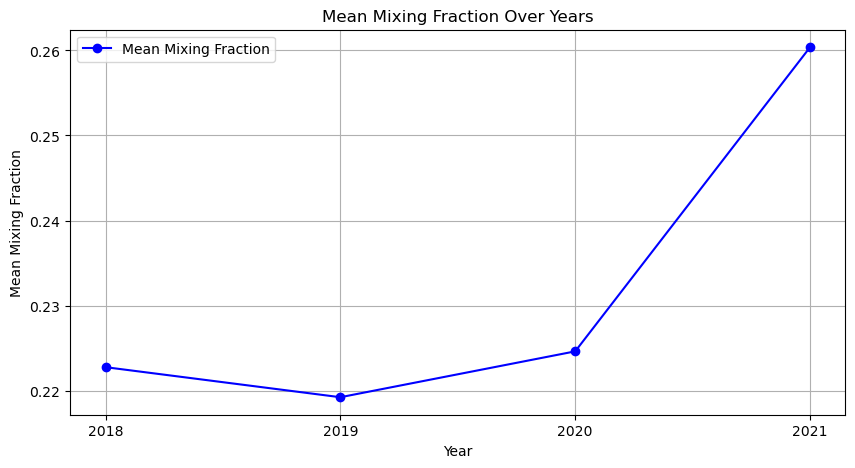

In [18]:
# Plot the posterior distributions for the fraction vs year
years = list(Summary_over_years.keys())
mean_fractions = [Summary_over_years[year]['Mean_fraction'] for year in years]
plt.figure(figsize=(10, 5))
plt.plot(years, mean_fractions, marker='o', linestyle='-', color='blue', label='Mean Mixing Fraction')
plt.xlabel('Year')
plt.ylabel('Mean Mixing Fraction')
plt.title('Mean Mixing Fraction Over Years')
plt.xticks(years)
plt.legend()
plt.grid()
plt.show()

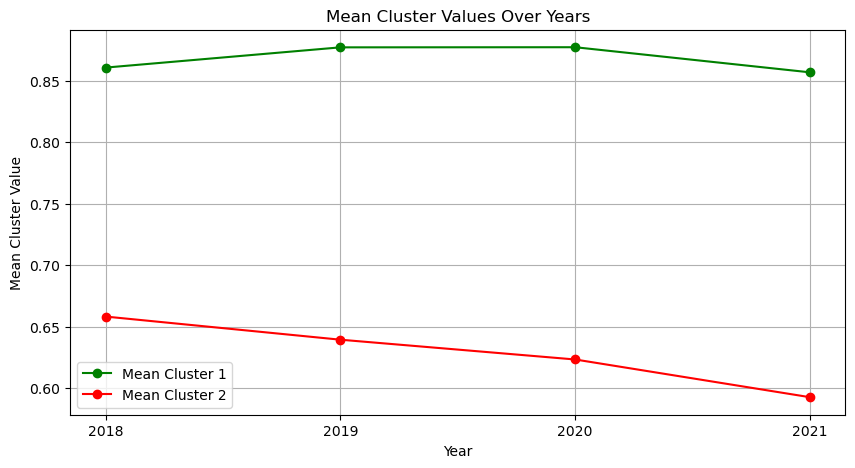

In [19]:
cluster_1_means = [Summary_over_years[year]['Mean_Cluster_1'] for year in years]
cluster_2_means = [Summary_over_years[year]['Mean_Cluster_2'] for year in years]
plt.figure(figsize=(10, 5))
plt.plot(years, cluster_1_means, marker='o', linestyle='-', color='green', label='Mean Cluster 1')
plt.plot(years, cluster_2_means, marker='o', linestyle='-', color='red', label='Mean Cluster 2')
plt.xlabel('Year')
plt.ylabel('Mean Cluster Value')
plt.title('Mean Cluster Values Over Years')
plt.xticks(years)
plt.legend()
plt.grid()
plt.show()  